<a href="https://colab.research.google.com/github/Codeblockz/Data-Science-Self-Projects/blob/main/Kaggle_Titanic_challege/Titanic_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Titanic Challenge Kaggle <br></br>
[source 1](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)  <br></br>
[source 2]( https://www.kaggle.com/lonnieqin/classification-with-sklearn-and-tensorflow)

In [1]:
from google.colab import files
from os.path import exists
file_exists = exists("/content/kaggle.json")
if (file_exists==False):
  files.upload()

Saving kaggle.json to kaggle.json


In [2]:
! pip install -q kaggle
!pip install --upgrade kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
 ! kaggle competitions download titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 11.0MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.33MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 58.9MB/s]


Start To work on geting data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [8]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Data Scrubing Replacing NAN values

In [10]:
# from source 2
# Replace NAN
embark_label = train["Embarked"].mode()[0]
train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())

test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())

In [14]:
# source 1
import string
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    print(big_string)
    return np.nan
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)


In [12]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Miss
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mrs
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mr


In [15]:
# Make cabin type
# Source 2
train["Cabin_type"] = train["Cabin"].apply(lambda cabin: cabin[0])
test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]

In [20]:
# make embeded values
train['Sex'] = train['Sex'].astype('category')
train['Cabin_type'] = train['Cabin_type'].astype('category')
train['Embarked'] = train['Embarked'].astype('category')
train['Sex_value'] = train['Sex'].cat.codes
train['Cabin_type_value'] = train['Cabin_type'].cat.codes
train['Embarked_value'] = train['Embarked'].cat.codes

test['Sex'] = test['Sex'].astype('category')
test['Cabin_type'] = test['Cabin_type'].astype('category')
test['Embarked'] = test['Embarked'].astype('category')
test['Sex_value'] = test['Sex'].cat.codes
test['Cabin_type_value'] = test['Cabin_type'].cat.codes
test['Embarked_value'] = test['Embarked'].cat.codes

## Survival Factors

In [22]:
# source 2
train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived              1.000000
Sex_value            -0.543351
Pclass               -0.338481
Cabin_type_value     -0.301116
Fare                  0.257307
Embarked_value       -0.167675
Parch                 0.081629
Age                  -0.069809
SibSp                -0.035322
family_member_size    0.016639
PassengerId          -0.005007
Name: Survived, dtype: float64

In [25]:
# Source 2
related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
related_columns.remove("Survived")
print(related_columns)

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value']


In [30]:
# For DNN
train_DNN = train[['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value']]
test_DNN = test[['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value']]

## Deep and Wide

In [54]:
categorical_feature_names = ["Pclass", "Sex_value", "Embarked_value", "Cabin_type_value"]
numerical_feature_names = ["Age", "Fare", "SibSp", "Parch", "family_member_size"]
categorical_features = [
    feature_column.indicator_column(
        feature_column.categorical_column_with_vocabulary_list(key, sorted(list(train[key].unique())))
    ) for key in categorical_feature_names
]
print(categorical_features)
numerical_features = [feature_column.numeric_column(key) for key in numerical_feature_names]
input_dictionary = dict()
inputs = dict()
for item in numerical_features:
    inputs[item.key] = tf.keras.layers.Input(name=item.key, shape=())
for item in categorical_features:
    #print(item.categorical_column.key)
    inputs[item.categorical_column.key] = tf.keras.layers.Input(name=item.categorical_column.key, shape=(), dtype="int32")

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex_value', vocabulary_list=(0, 1), dtype=tf.int8, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Embarked_value', vocabulary_list=(0, 1, 2), dtype=tf.int8, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Cabin_type_value', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8), dtype=tf.int8, default_value=-1, num_oov_buckets=0))]


In [69]:
# Source 2 
# Helper Features
def features_and_labels(row_data):
    label = row_data.pop("Survived")
    features = row_data
    return features, label

def create_dataset(pattern, epochs=1, batch_size=32, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(features_and_labels)
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=128).repeat(epochs)
  # print(dataset)
    dataset = dataset.prefetch(1)
  # print("after prefetch\n",dataset)
    return dataset

def create_test_dataset(pattern, batch_size=32):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(lambda features: features)
    dataset = dataset.prefetch(1)
    return dataset

In [70]:
train_data, val_data = train_test_split(
    train[categorical_feature_names + numerical_feature_names + ["Survived"]],
    test_size=.2,
    random_state=np.random.randint(0, 1000)
)
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test[categorical_feature_names + numerical_feature_names].to_csv("test_data.csv", index=False)
batch_size = 32
train_dataset = create_dataset("train_data.csv", batch_size=batch_size, mode='train')
val_dataset = create_dataset("val_data.csv", batch_size=val_data.shape[0], mode='eval').take(1)
test_dataset = create_test_dataset("test_data.csv", batch_size = test.shape[0]).take(1)

In [61]:
# D&W Model
def build_deep_and_wide_model():
    deep = tf.keras.layers.DenseFeatures(numerical_features, name='deep')(inputs)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    wide = tf.keras.layers.DenseFeatures(categorical_features, name='wide')(inputs)
    wide = tf.keras.layers.Dense(32, activation='relu')(wide)
    combined = tf.keras.layers.concatenate(inputs=[deep, wide], name='combined')
    output = tf.keras.layers.Dense(1, activation="sigmoid")(combined)
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

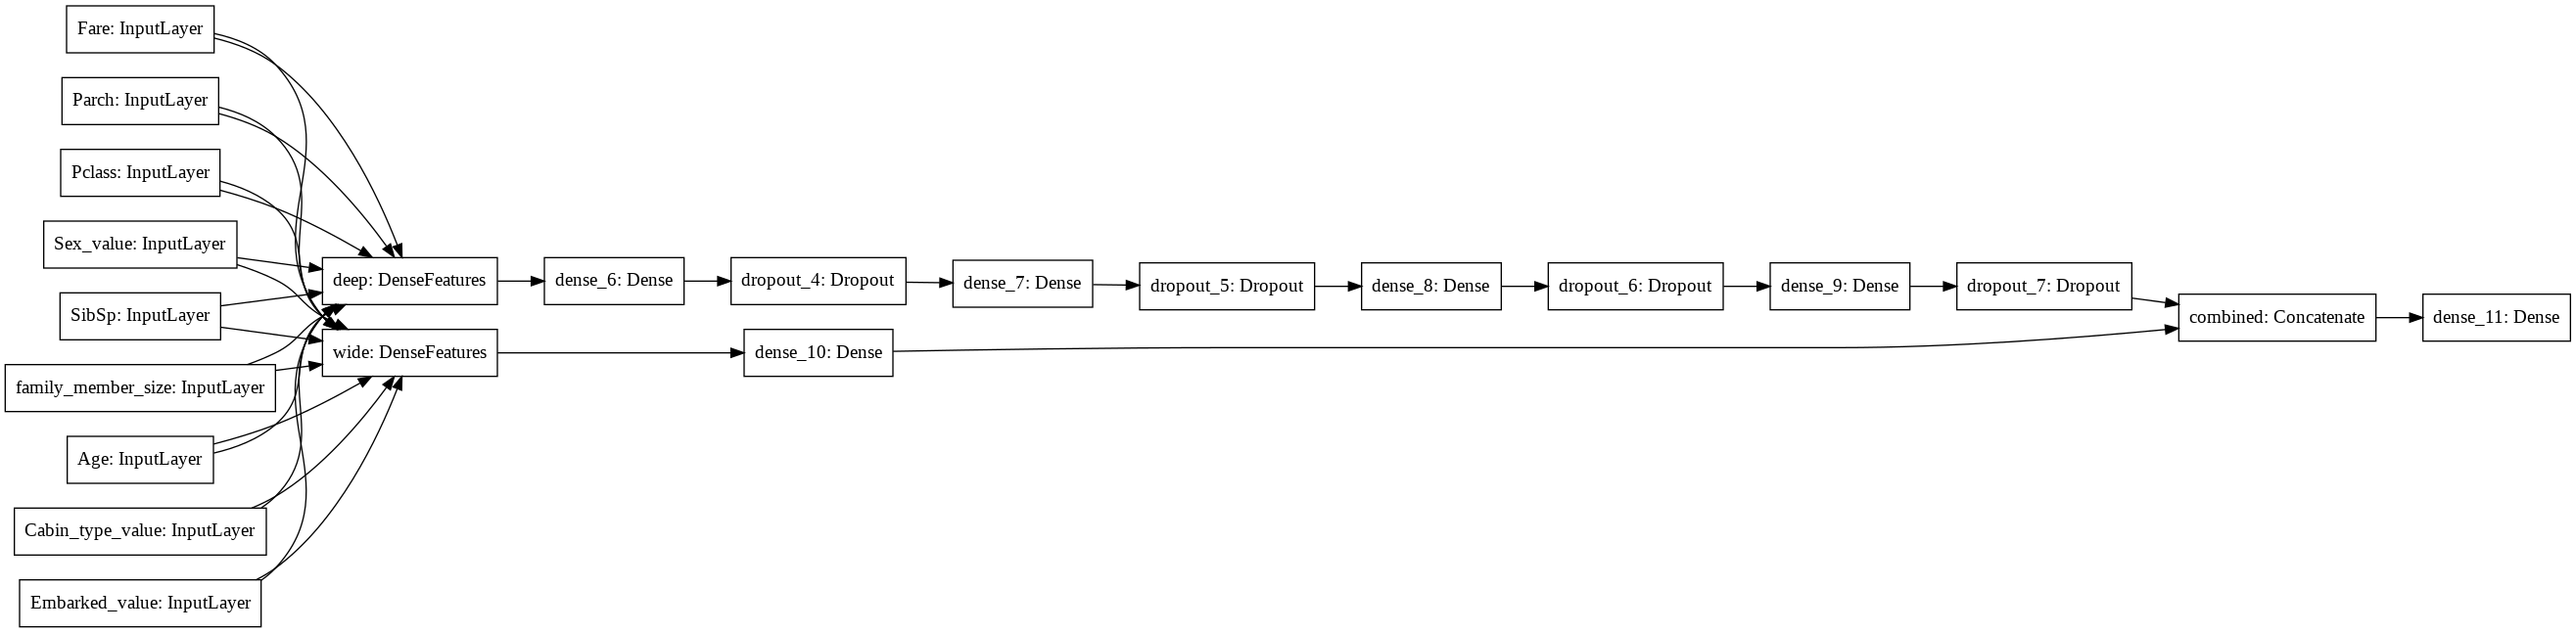

In [62]:
deep_and_wide_model = build_deep_and_wide_model()
tf.keras.utils.plot_model(deep_and_wide_model, show_shapes=False, rankdir='LR')

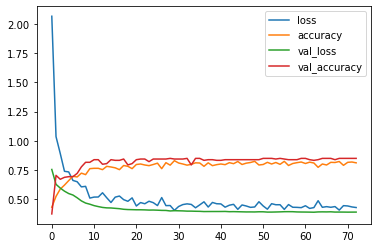

In [63]:
epochs = 400
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
steps_per_epoch = train_data.shape[0] // batch_size
history = deep_and_wide_model.fit(
    train_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [84]:
# y_pred =  np.array(deep_and_wide_model.predict(val_dataset) > 0.5, dtype=int).reshape(-1)
y_pred = np.array(deep_and_wide_model.predict(val_dataset)>.5,dtype=int).reshape(-1)
score = accuracy_score(val_data["Survived"], y_pred)
print("y_pred", y_pred)
print("Accuracy score:", score)
print(sklearn.metrics.classification_report(val_data["Survived"], y_pred))
Survived = np.argmax(deep_and_wide_model.predict(test_dataset), axis=-1).reshape(-1)
print(Survived.shape)

y_pred [0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Accuracy score: 0.5754189944134078
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       118
           1       0.33      0.25      0.28        61

    accuracy                           0.58       179
   macro avg       0.50      0.50      0.49       179
weighted avg       0.55      0.58      0.56       179

(418,)


In [89]:
deep_and_wide_model.predict(test_dataset)

array([[0.27722627],
       [0.9817473 ],
       [0.85154176],
       [0.1375544 ],
       [0.07990527],
       [0.11005333],
       [0.722685  ],
       [0.08921292],
       [0.47151676],
       [0.14275068],
       [0.40538055],
       [0.72108525],
       [0.7107433 ],
       [0.51095825],
       [0.9550094 ],
       [0.11042038],
       [0.30401802],
       [0.08839965],
       [0.97692174],
       [0.488933  ],
       [0.10824212],
       [0.97212774],
       [0.30294493],
       [0.7204327 ],
       [0.9541751 ],
       [0.08985445],
       [0.09531456],
       [0.27139783],
       [0.10905769],
       [0.30660492],
       [0.08982423],
       [0.11231801],
       [0.9770757 ],
       [0.09204102],
       [0.488933  ],
       [0.7215595 ],
       [0.2802882 ],
       [0.11204788],
       [0.26695338],
       [0.49434114],
       [0.07990527],
       [0.91757405],
       [0.0912551 ],
       [0.30257043],
       [0.09211326],
       [0.09116858],
       [0.8516909 ],
       [0.492